In [1]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import os
import sys
import csv
import talib
from   scipy.stats       import norm
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf

In [2]:
df_ = pd.read_csv("/home/sambu/src/dev/binance-history-downloader/data/klines/spot-1m/minute/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.DatetimeIndex(df_.index)
df_

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2023-08-31 23:55:00,25936.49,25936.49,25923.68,25929.47,18.664000
2023-08-31 23:56:00,25929.48,25941.68,25929.47,25941.68,31.446110
2023-08-31 23:57:00,25941.68,25941.68,25936.75,25936.76,15.884310


In [3]:
timeframe_by_minute = 30

In [4]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.32,4261.45,11.308926
2017-08-17 04:30:00,4280.00,4313.62,4267.99,4308.83,35.872083
2017-08-17 05:00:00,4308.83,4328.69,4304.31,4320.00,21.048648
2017-08-17 05:30:00,4320.00,4320.00,4291.37,4315.32,2.186268
2017-08-17 06:00:00,4315.32,4330.29,4309.37,4311.02,3.566277
...,...,...,...,...,...
2023-08-31 21:30:00,25923.91,26037.97,25900.20,26024.57,646.753620
2023-08-31 22:00:00,26024.57,26035.11,25976.15,25995.47,688.424780
2023-08-31 22:30:00,25995.47,26072.73,25995.46,26053.96,451.977030


mean    : 50.609033305557105
std.dev : 11.69185643057027
sigma lower : 27.2
sigma upper : 74.0


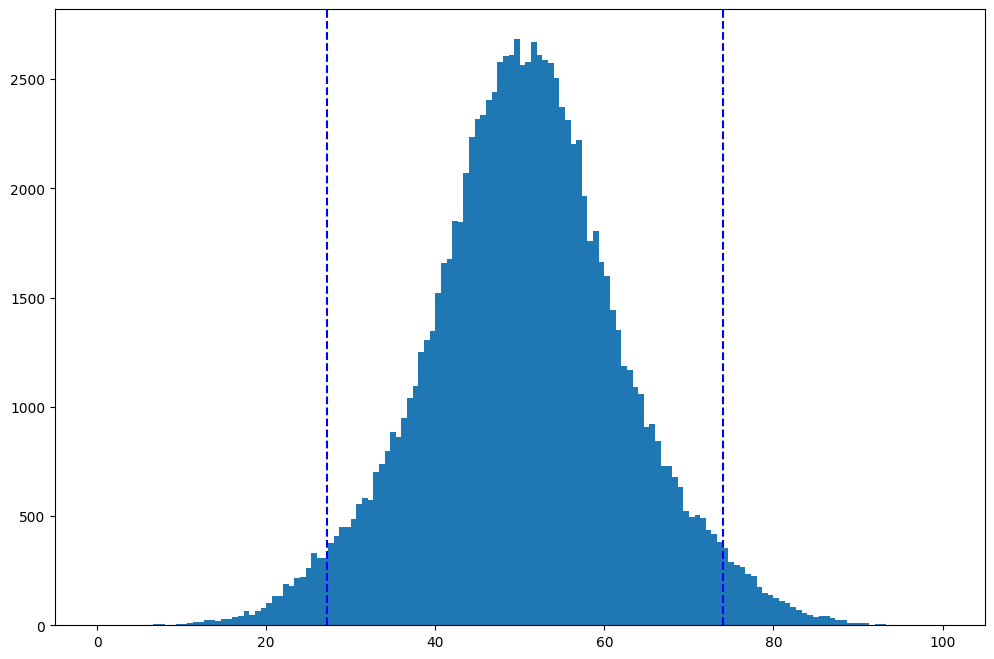

In [5]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [6]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    959
-1.0    891
Name: count, dtype: int64

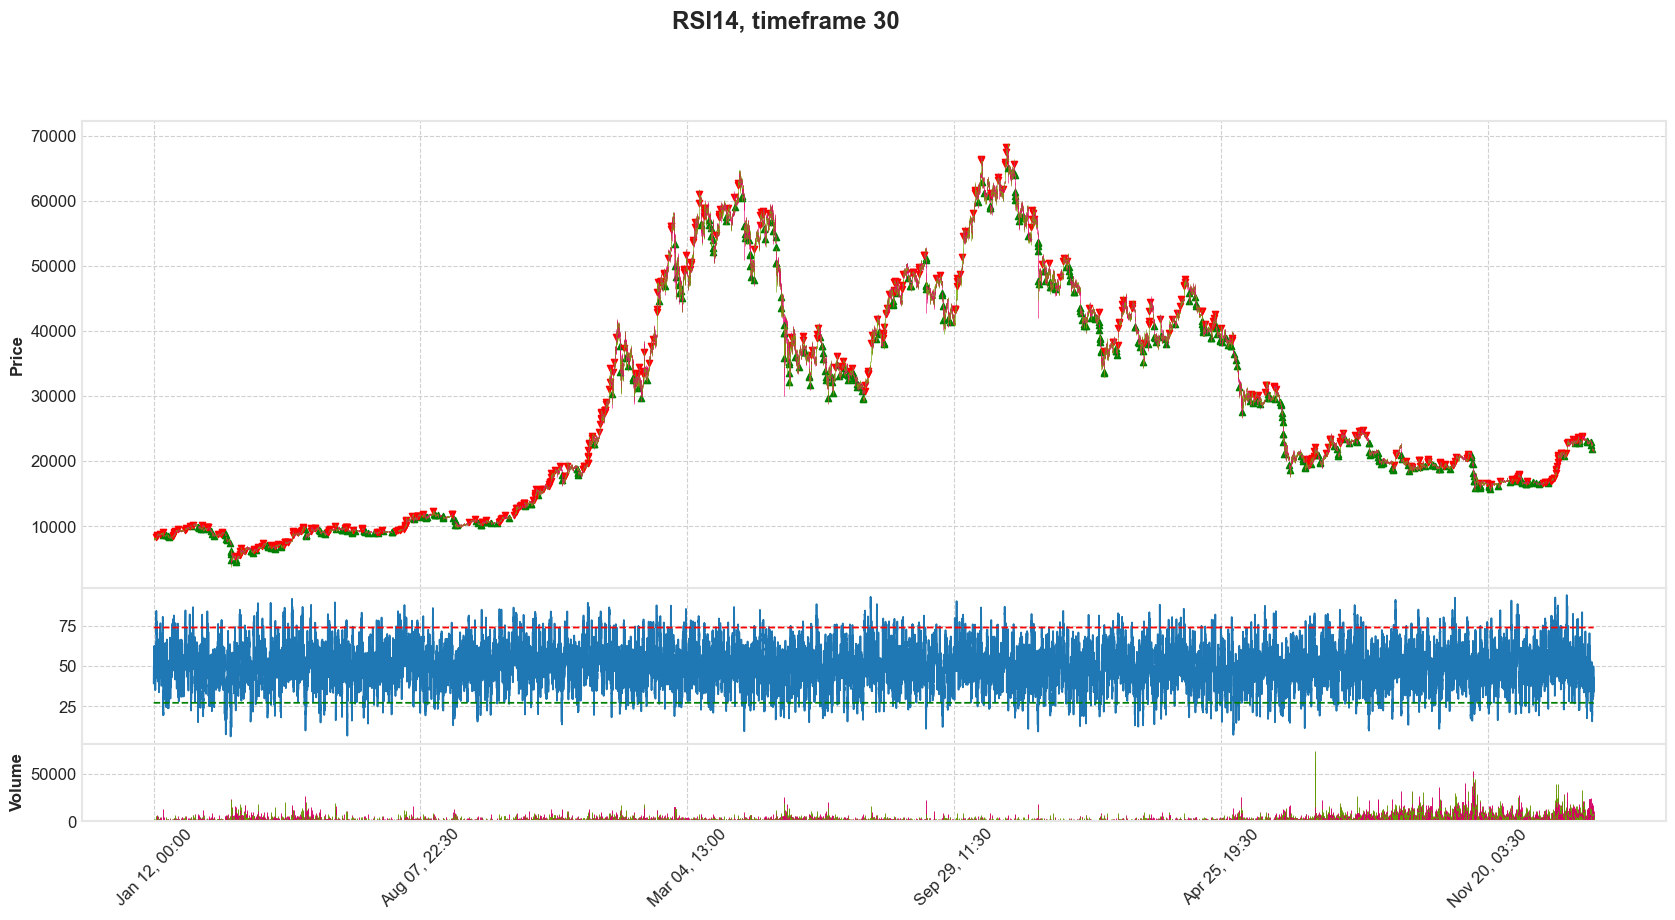

In [8]:
plot_df = df["2020-01-12":"2023-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=20, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=20, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [9]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

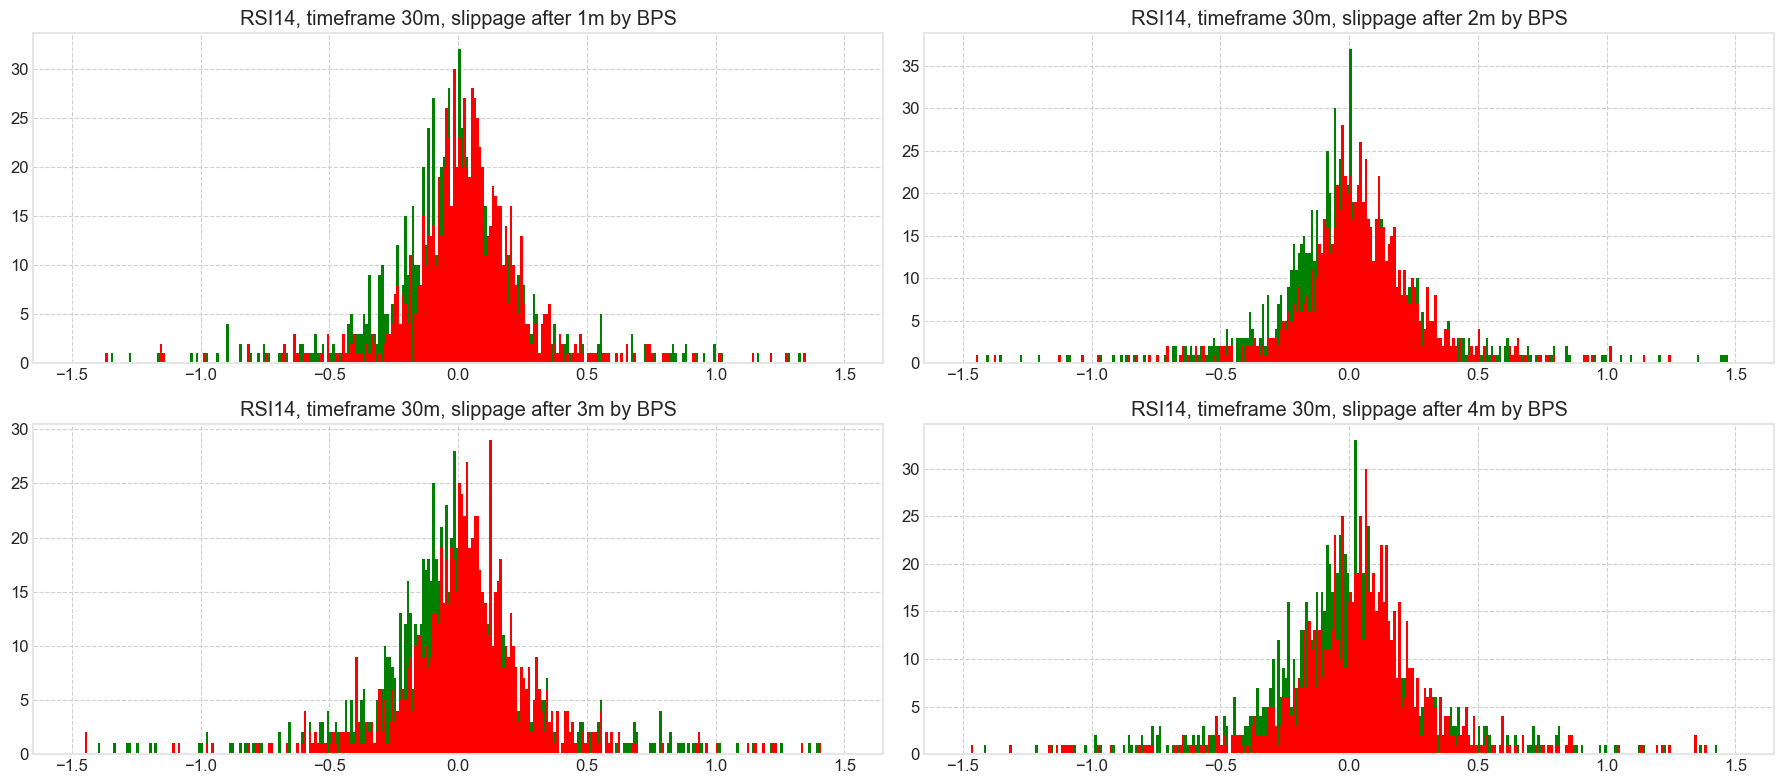

In [10]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-1.5, 1.5)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [11]:
timeframe_by_hours  = 1
timeframe_by_minute = timeframe_by_hours*60

In [12]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2023-08-31 19:00:00,26292.24,26319.40,25928.00,26162.79,4521.912720
2023-08-31 20:00:00,26162.79,26194.86,25959.72,26022.61,2429.776060
2023-08-31 21:00:00,26022.61,26037.97,25655.01,26024.57,4573.055290


mean    : 50.69078876797333
std.dev : 12.313517026750512
sigma lower : 26.1
sigma upper : 75.3


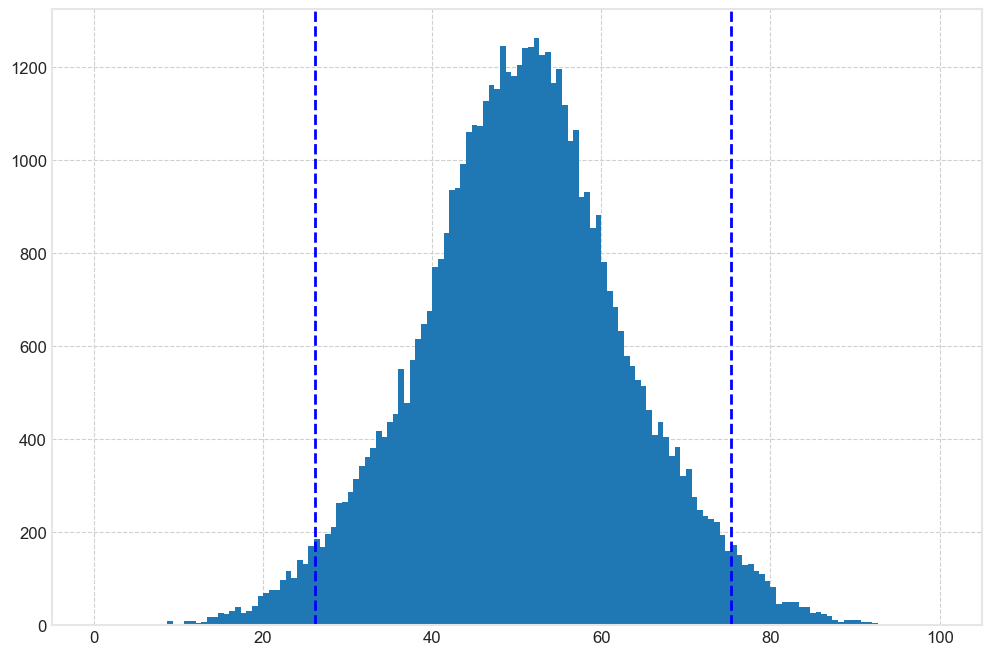

In [13]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [14]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    439
-1.0    428
Name: count, dtype: int64

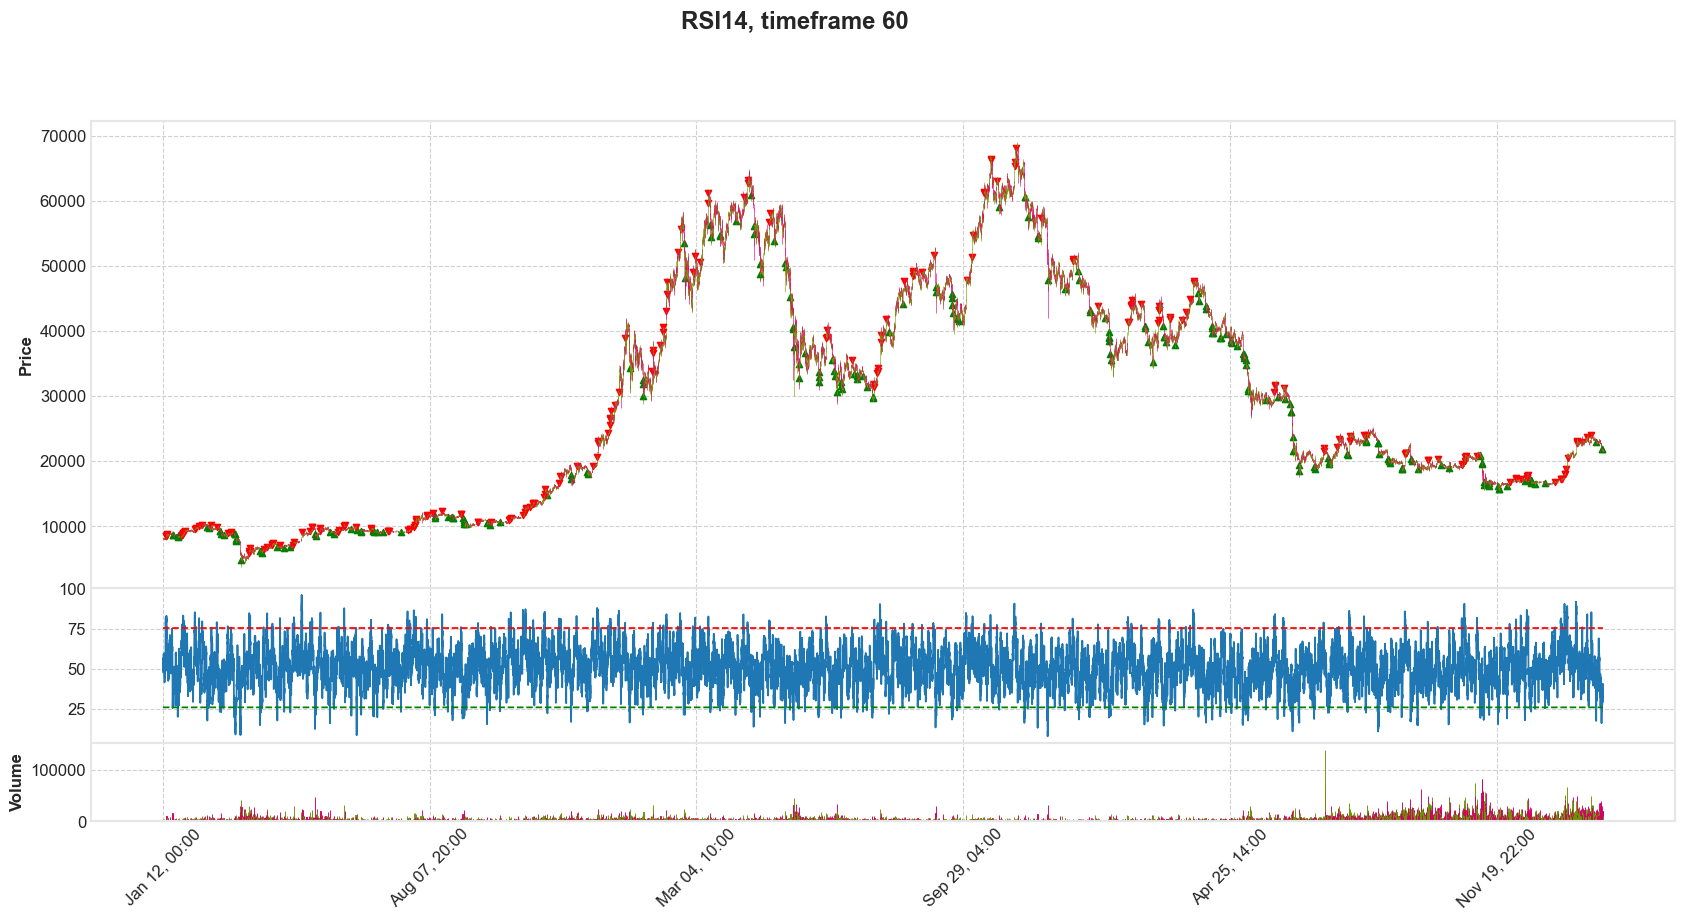

In [15]:
plot_df = df["2020-01-12":"2023-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=20, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=20, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [16]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

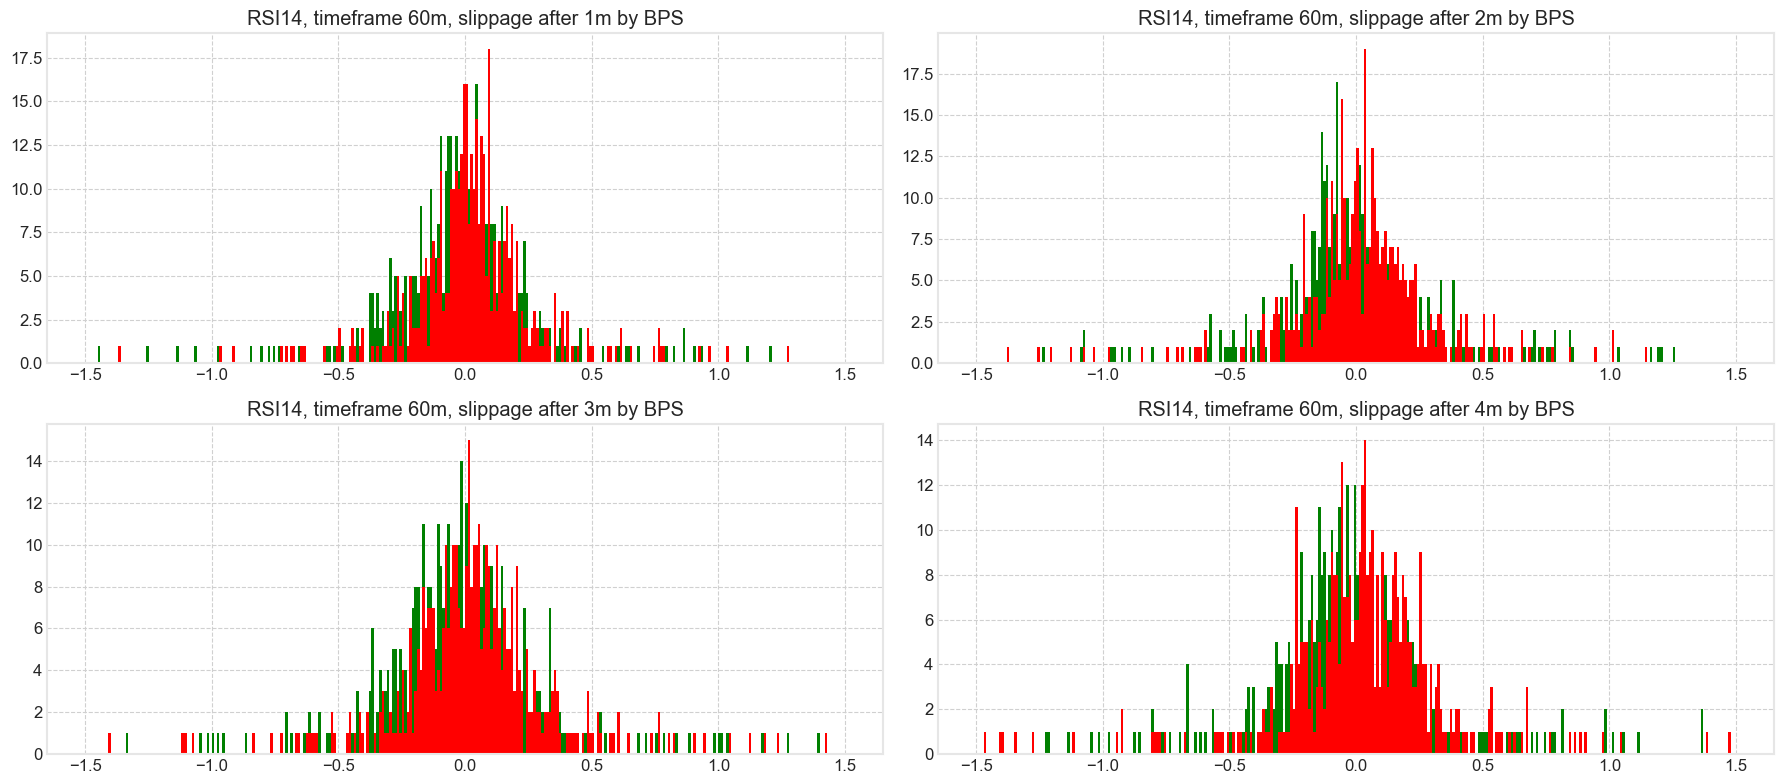

In [17]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-1.5, 1.5)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [18]:
timeframe_by_hours  = 2
timeframe_by_minute = timeframe_by_hours*60

In [19]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4328.69,4261.32,4315.32,70.415925
2017-08-17 06:00:00,4315.32,4349.99,4287.41,4349.99,11.672940
2017-08-17 08:00:00,4333.32,4445.78,4333.32,4444.00,11.736430
2017-08-17 10:00:00,4441.10,4485.39,4399.81,4427.30,51.883452
2017-08-17 12:00:00,4427.30,4459.00,4411.00,4459.00,54.344834
...,...,...,...,...,...
2023-08-31 14:00:00,27149.99,27192.78,26803.73,26922.01,6241.037140
2023-08-31 16:00:00,26922.01,26924.87,26133.94,26329.07,13662.734210
2023-08-31 18:00:00,26329.08,26387.32,25928.00,26162.79,6349.377170


mean    : 50.85741416415367
std.dev : 12.826202852204846
sigma lower : 25.2
sigma upper : 76.5


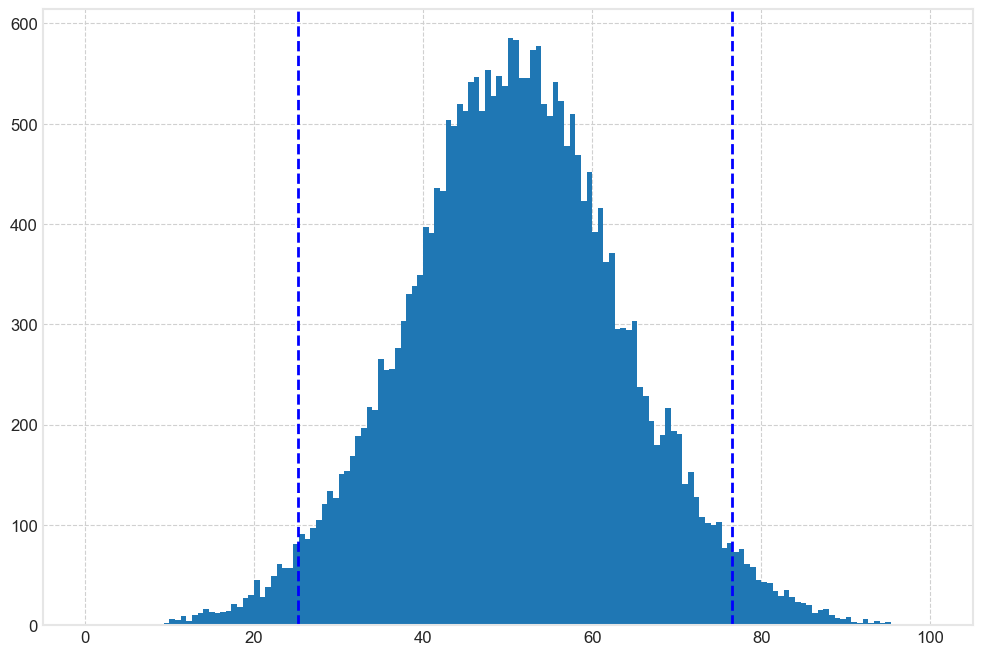

In [20]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [21]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
-1.0    198
 1.0    180
Name: count, dtype: int64

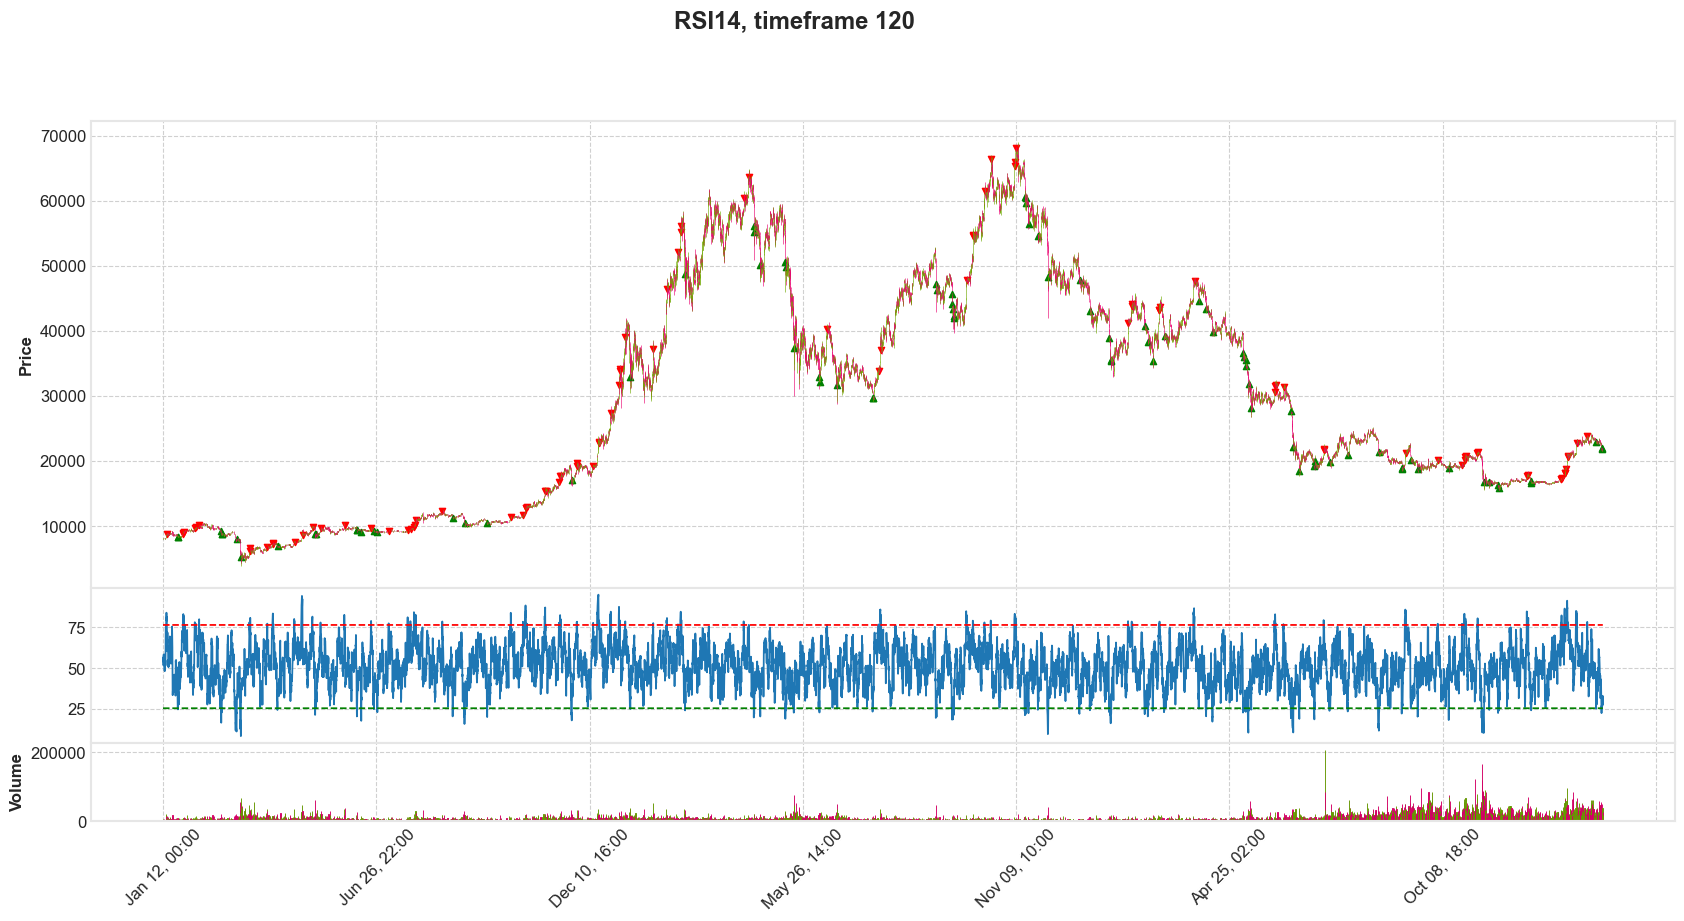

In [22]:
plot_df = df["2020-01-12":"2023-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=20, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=20, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [23]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

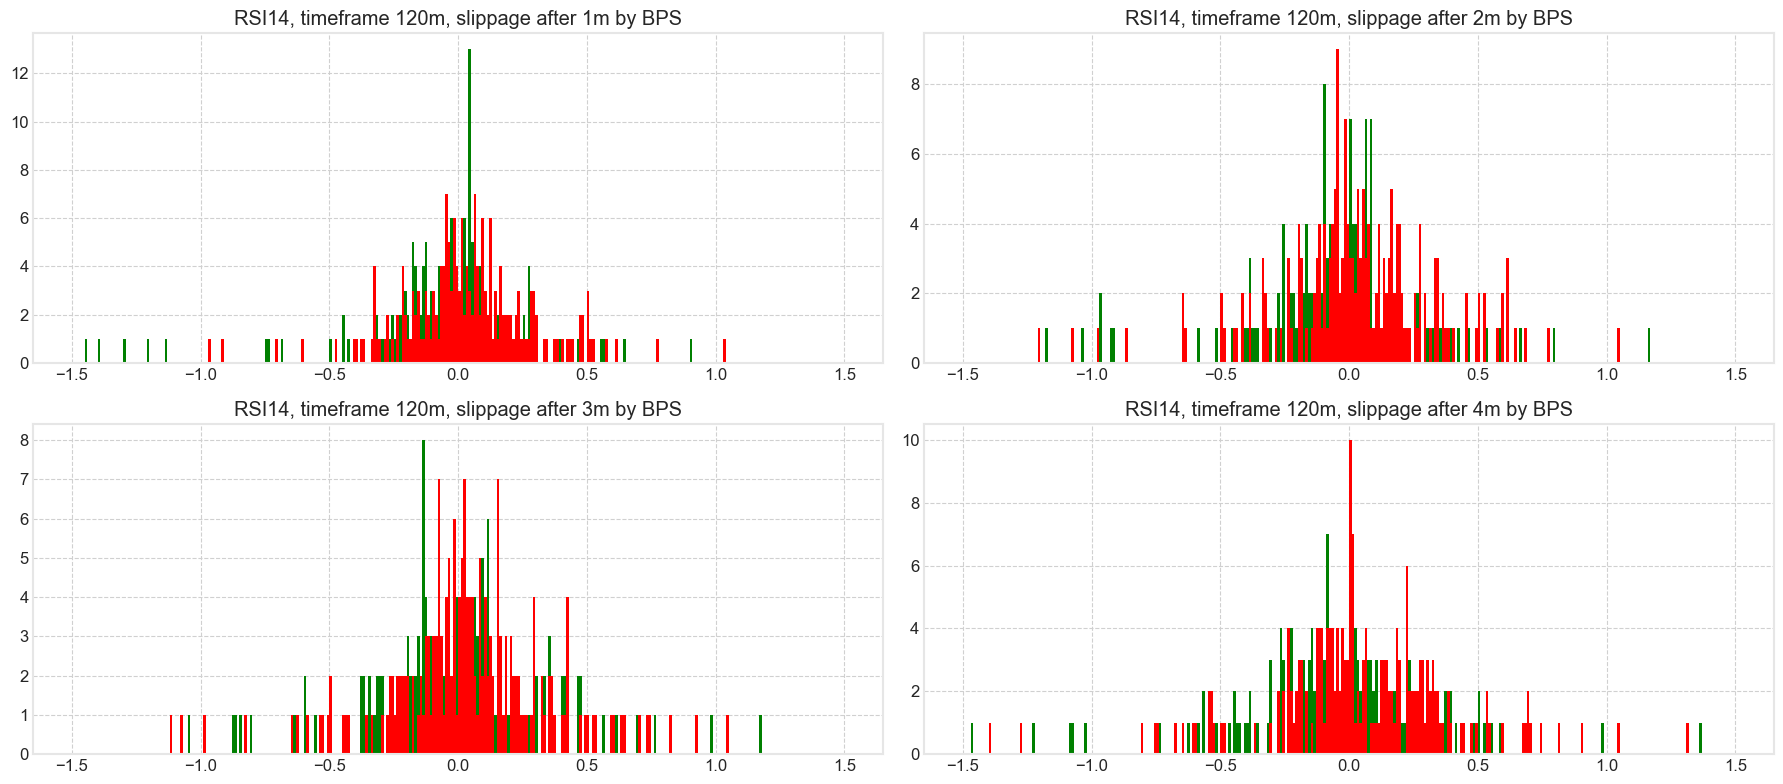

In [24]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-1.5, 1.5)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [25]:
timeframe_by_hours  = 4
timeframe_by_minute = timeframe_by_hours*60

In [26]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,4427.30,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,4352.34,4354.84,4200.74,4325.23,225.109716
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913
...,...,...,...,...,...
2023-08-31 04:00:00,27217.28,27294.97,27215.00,27261.03,2206.161810
2023-08-31 08:00:00,27261.03,27587.51,27184.99,27303.96,6087.659120
2023-08-31 12:00:00,27303.95,27315.47,26803.73,26922.01,11366.939360


mean    : 51.04008829087617
std.dev : 13.379876670592092
sigma lower : 24.3
sigma upper : 77.8


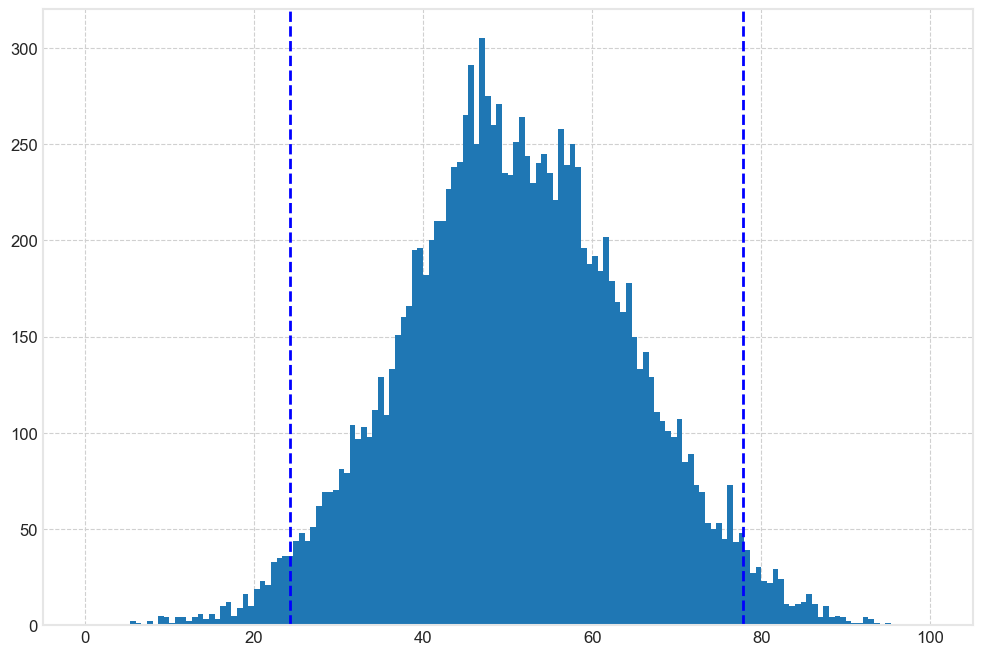

In [27]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [28]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
-1.0    100
 1.0     92
Name: count, dtype: int64

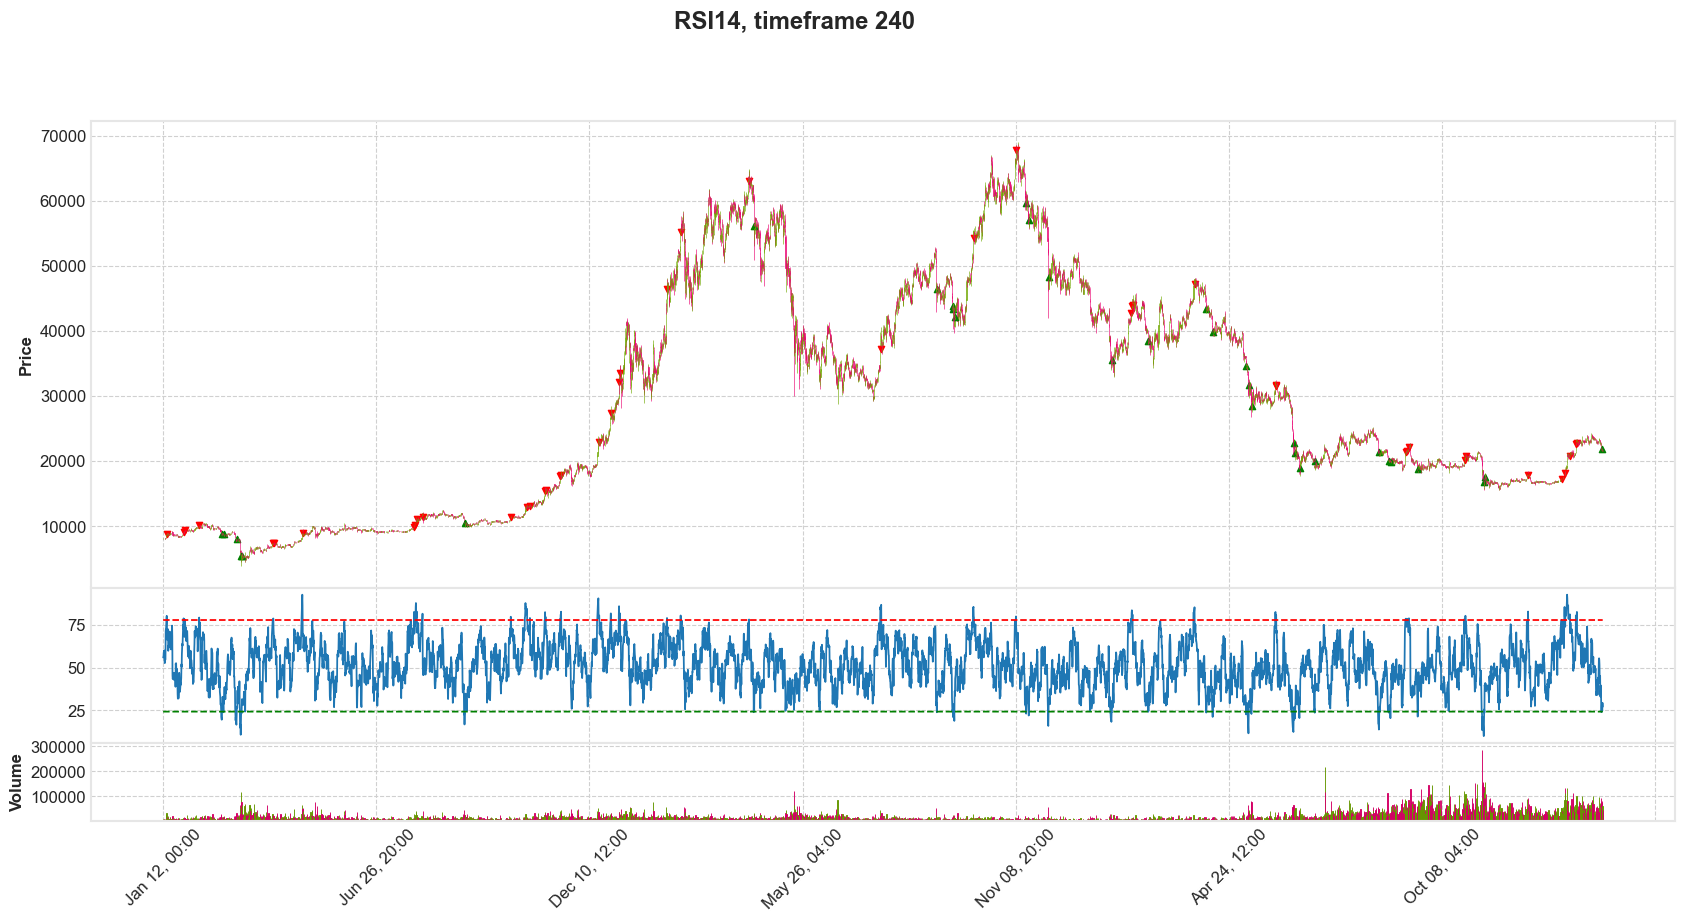

In [29]:
plot_df = df["2020-01-12":"2023-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=20, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=20, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [30]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

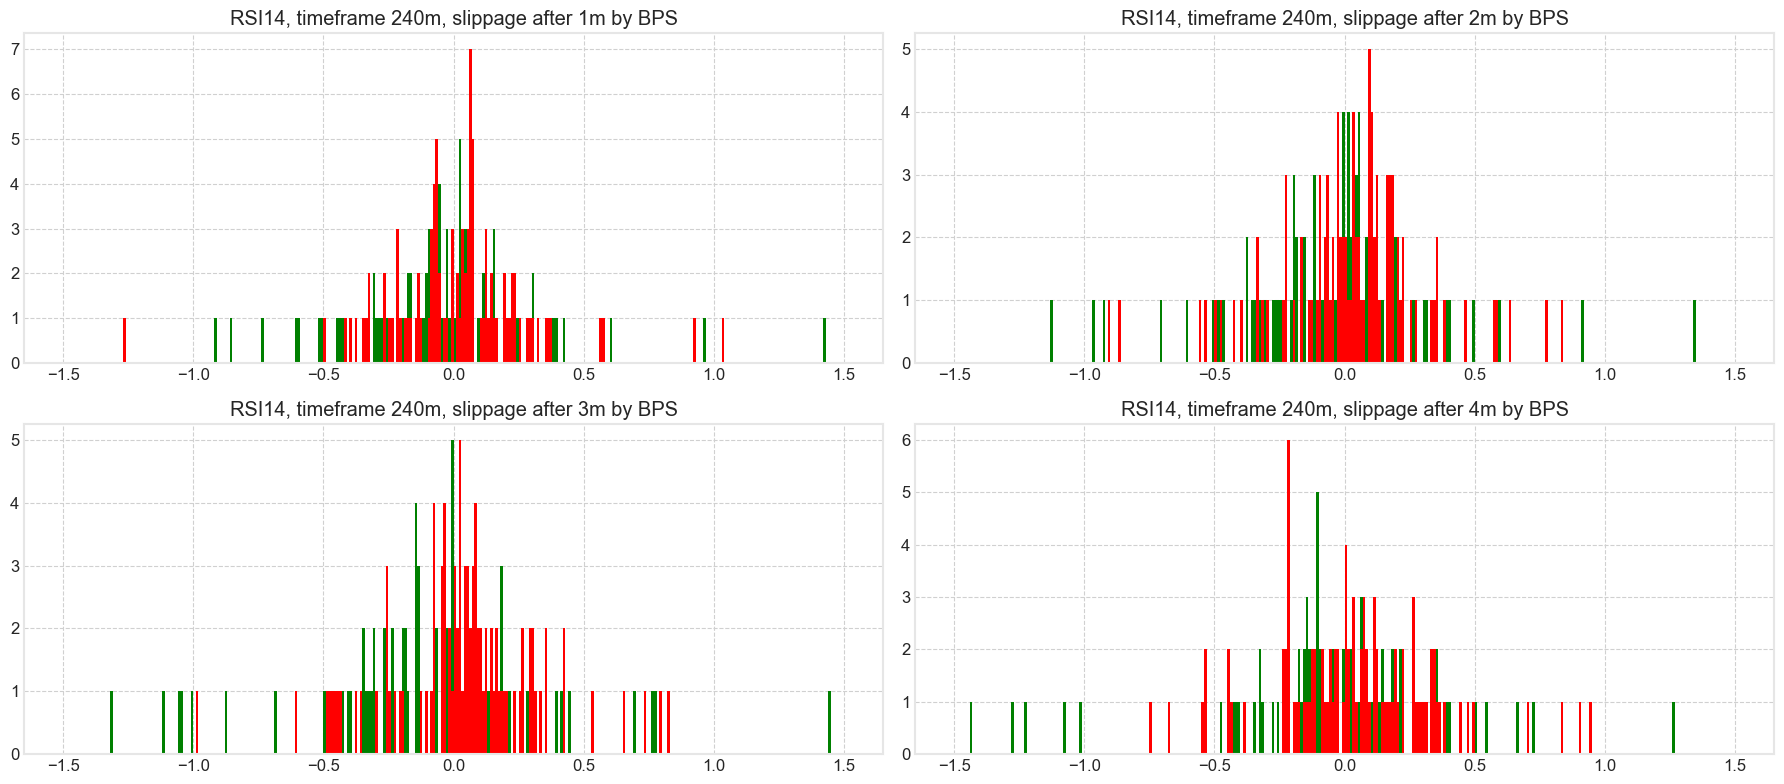

In [31]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-1.5, 1.5)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [32]:
timeframe_by_hours  = 12
timeframe_by_minute = timeframe_by_hours*60

In [33]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 00:00:00,4261.48,4485.39,4261.32,4427.30,145.708747
2017-08-17 12:00:00,4427.30,4485.39,4200.74,4285.08,649.441630
2017-08-18 00:00:00,4285.08,4371.52,4134.61,4340.31,720.722201
2017-08-18 12:00:00,4340.31,4340.31,3938.77,4108.37,479.166063
2017-08-19 00:00:00,4108.37,4184.69,3850.00,3957.60,298.518569
...,...,...,...,...,...
2023-08-29 12:00:00,25975.54,28142.85,25964.79,27716.34,63602.451530
2023-08-30 00:00:00,27716.34,27768.57,27280.99,27338.51,15138.751250
2023-08-30 12:00:00,27338.52,27464.45,27017.24,27299.99,20309.507230


mean    : 51.454638966303285
std.dev : 13.92530512644092
sigma lower : 23.6
sigma upper : 79.3


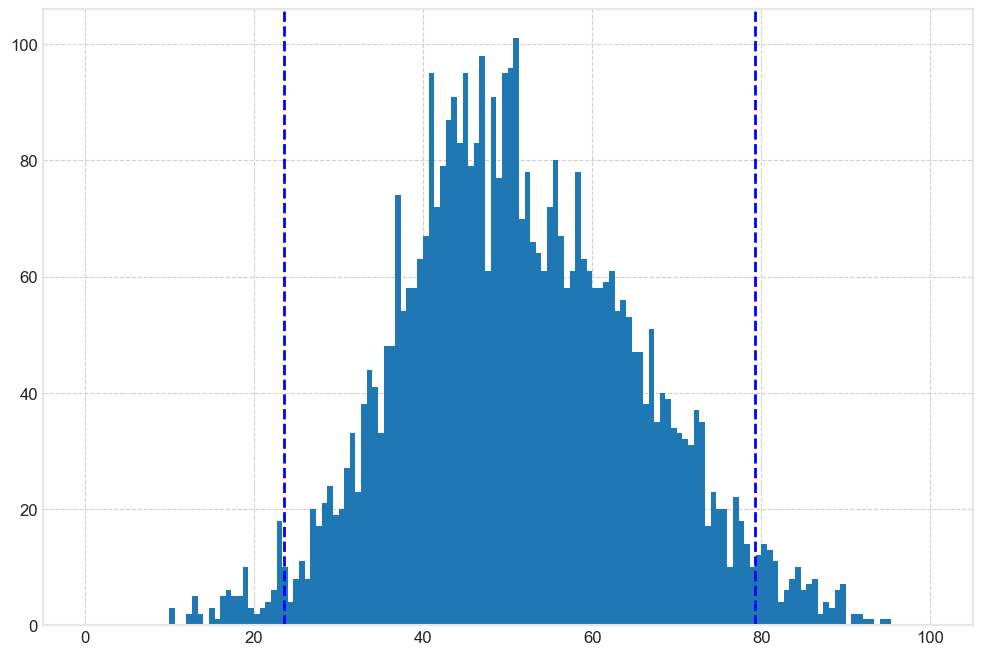

In [34]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [35]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
-1.0    37
 1.0    24
Name: count, dtype: int64

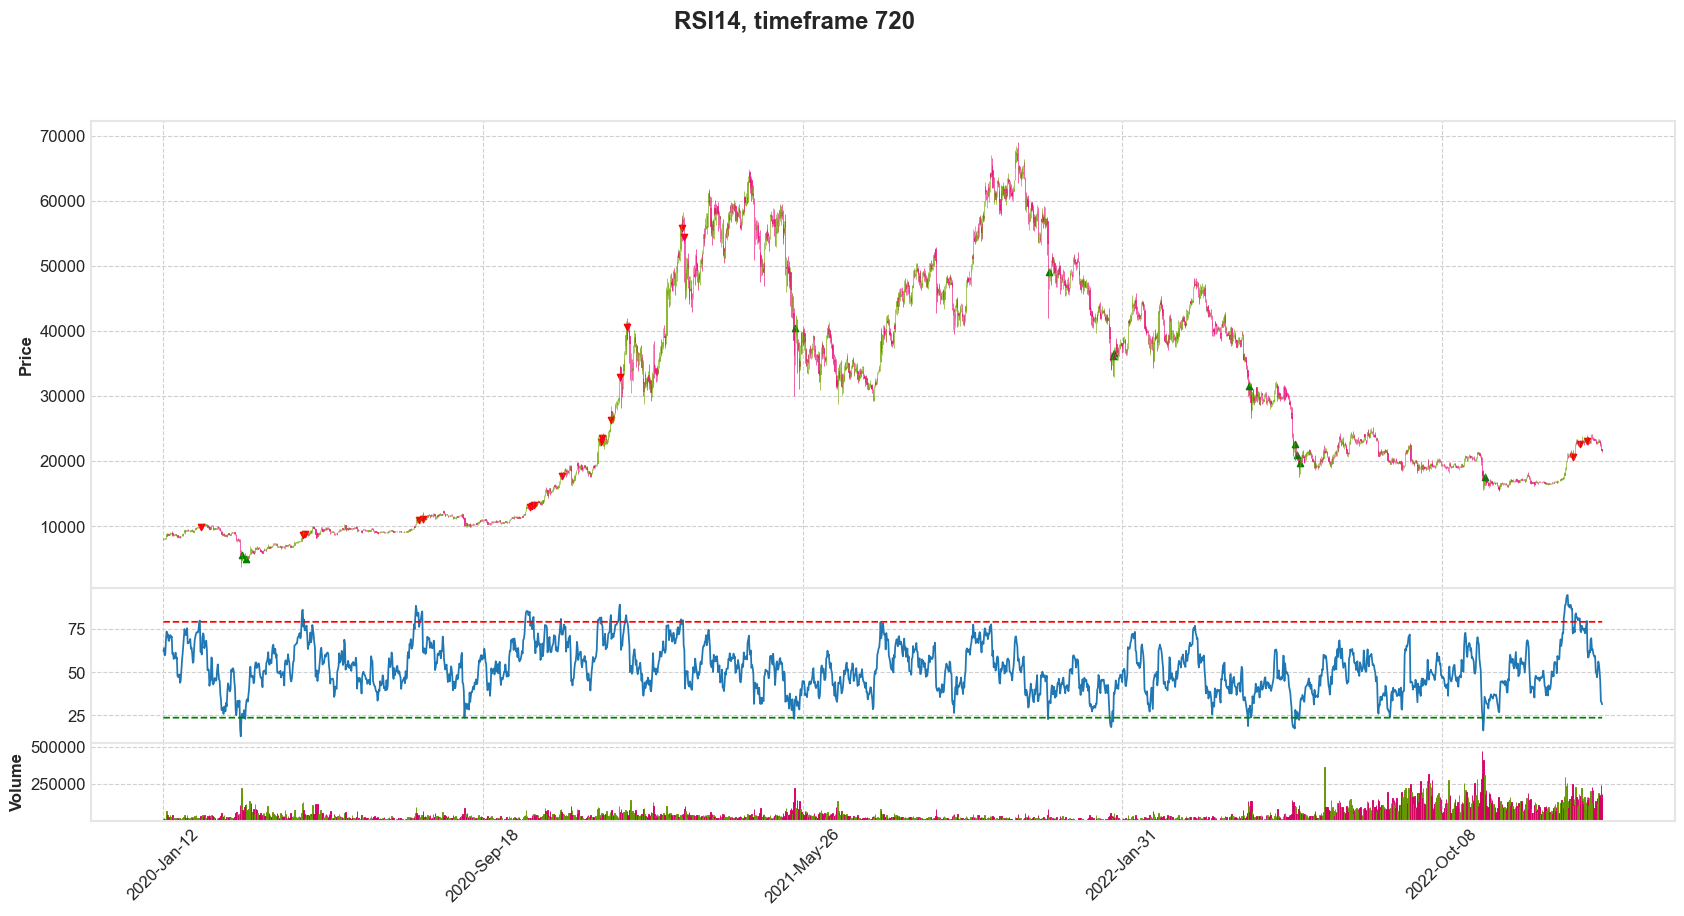

In [36]:
plot_df = df["2020-01-12":"2023-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=20, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=20, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [37]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

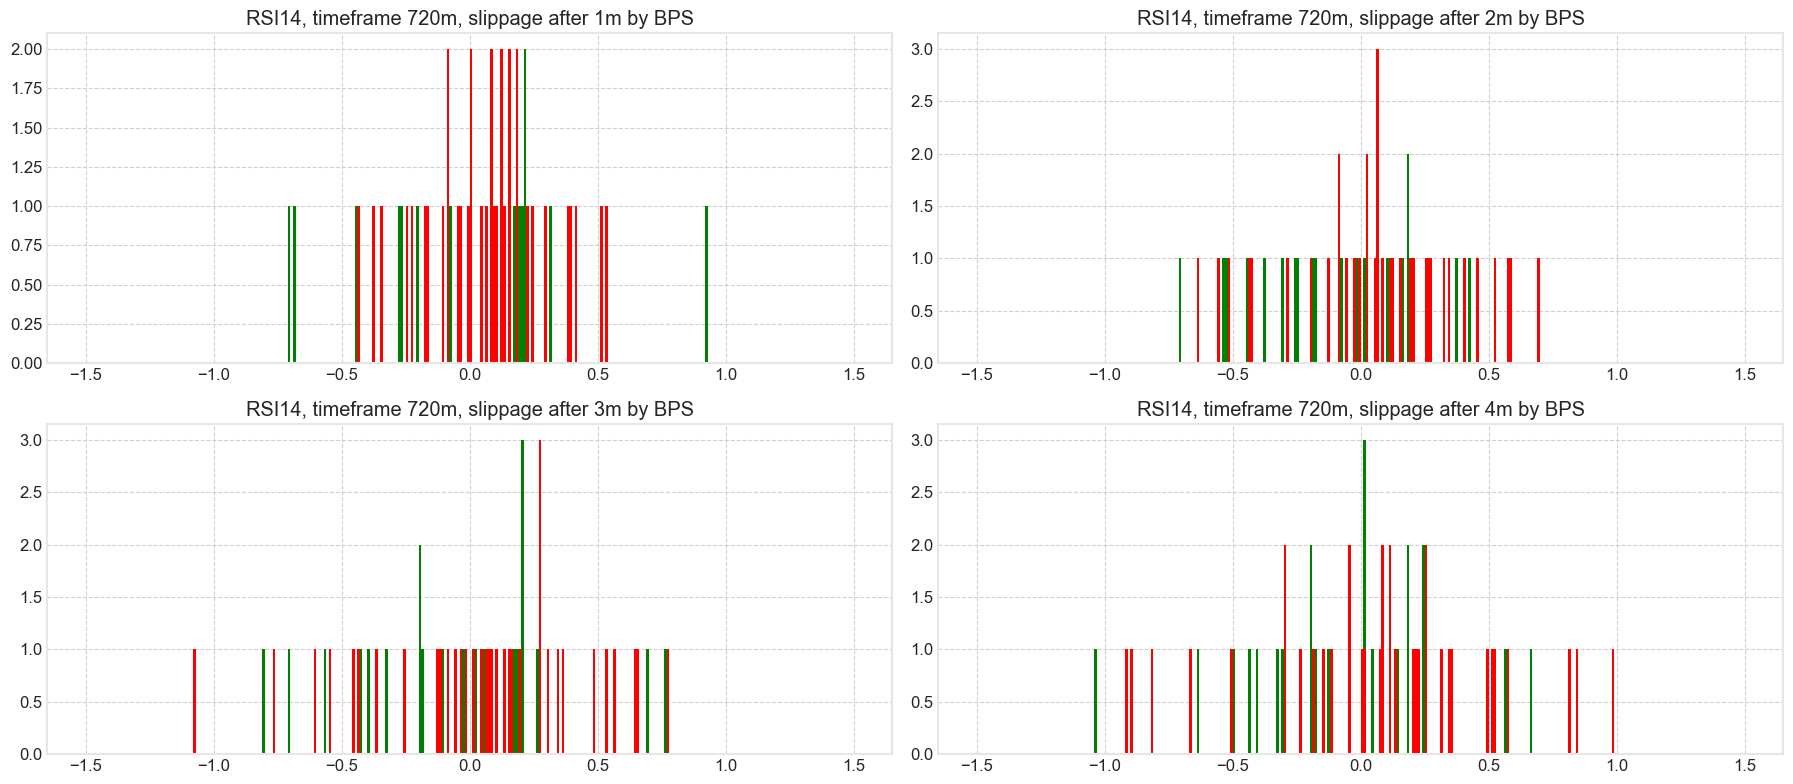

In [38]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-1.5, 1.5)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();